## Import Functionality

In [1]:
from utils import (get_data,train_and_tune_xgboost_regressor,save_model,
                   load_model,assign_treatment,save_optimal_treatment_as_json,
                   dictionry_to_class, plot_feature_importance,plot_correlation_top_features)
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import clear_output


## Set configs


In [2]:
#Define the configurations as a dictionary (*for further research, it is preferable to move it into a separate file out of the code).

configs_dict = dict(train_data_path = "data/train_home_assignment_.csv",
                   target_col = "org_price_usd_following_30_days",
                   columns_to_drop = ["treatment", "org_price_usd_following_30_days_after_impact"],
                   models_directory = "models",
                   model_name = "xbg_regressor_model_task1",
                   time_format = "%Y_%m_%d-%H_%M_%S",
                   model_file_type = "json",
                   model_path = 'models/xbg_regressor_model_task1_2023_04_15-22_14_53.json',
                   treatment_col_name = "treatment",
                   new_treatment_col_name = "optimal_treatment",
                   data_directory = "data",
                   test_size = 0.2,
                   treatment_values = [2,10])

# Convert dictionary into class 
configs = dictionry_to_class(configs_dict)

# Get data 

In [3]:
# Load data, remove unnecessary columns, split to train test 
X_train, X_test, y_train, y_test = get_data(path = configs.train_data_path, 
                                            target_col = configs.target_col, 
                                            test_size = configs.test_size,
                                            columns_to_drop = configs.columns_to_drop)

## Transormation, training and tuning

In [8]:
# Run data trasformation, grid search and cross validation
grid_search = train_and_tune_xgboost_regressor(X_train = X_train,
                                               y_train= y_train,
                                               numeric_cols = X_train.columns, 
                                               loss= 'squarederror',
                                               verbose = 2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=   4.0s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=   4.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=   4.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total tim

[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=  12.6s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=  12.8s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=  11.8s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=  13.3s
[CV] END regressor__colsample_bytree=0.7, regressor_

[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  21.0s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  21.7s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  21.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=5, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  21.2s
[CV] END regressor__colsample_bytree=0.7, regressor_

[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=7, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.5; total time=  32.5s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=7, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.5; total time=  31.9s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=7, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.5; total time=  29.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.01, regressor__max_depth=7, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.5; total time=  30.0s
[CV] END regressor__colsample_bytree=0.7, regressor_

[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=  20.9s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=  20.6s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=  12.9s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=3, regressor__n_estimators=200, regressor__objective=reg:squarederror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=  11.3s
[CV] END regressor__colsample_bytree=0.7, regressor__lea

[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=   8.6s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=   8.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=   8.4s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.5; total time=   8.5s
[CV] END regressor__colsample_bytree=0.7, regressor__lea

[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  11.8s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  12.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  14.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__reg_alpha=0.5, regressor__reg_lambda=0.1; total time=  13.2s
[CV] END regressor__colsample_bytree=0.7, regressor__lea

### Save and load model

In [9]:
# Save model as json
save_model(model = grid_search,
           directory = configs.models_directory,
           name = configs.model_name,
           time_format = configs.time_format,
           file_type = configs.model_file_type)

'models/xbg_regressor_model_task1_2023_04_15-22_14_53.json'

In [4]:
# Load model
xgb_regressor = load_model(model_path = configs.model_path)

# Evaluate 

RMSE on train 

In [5]:
y_train_pred = xgb_regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mse**0.5

77.72924639158381

In [6]:
r2_score(y_train, y_train_pred)

0.7631500227121819

RMSE on test 

In [7]:
y_test_pred = xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mse**0.5

103.18246458001887

In [8]:
r2_score(y_test, y_test_pred)

0.5800145075077519

# Summary

The README.md file will provide a discussion of the following results:

#### Feature importance for squarederror

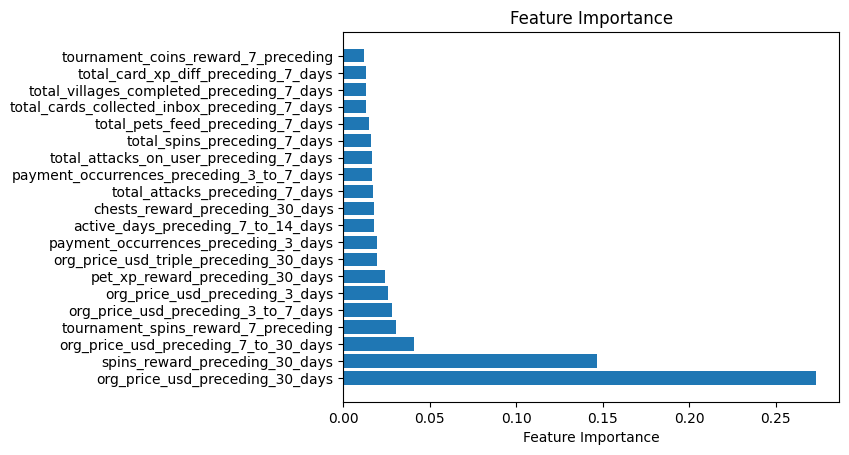

In [9]:
feature_importances=xgb_regressor.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = X_train.columns
plot_feature_importance(feature_importances = feature_importances,
                        feature_names = feature_names,
                        top_n = 20)

Before picking the top 3 features, lets take alook over the correlations of theses features 

In [ ]:
for i in range(2,21):
    plot_correlation_top_features(df = X_train,
                                  top_n = i , 
                                  feature_importances=feature_importances, 
                                  feature_names = feature_names)
    clear_output(wait=True)

<p align="center">
    <img src="https://raw.githubusercontent.com/razisamuely/MoonActive/main/gif/correlation.gif?token=GHSAT0AAAAAAB6GIEH4EAD5TRLM2UEEHQW4ZB27NRQ"  width="900" height="700">
</p>



# log loss experimants

In [11]:
# Run data trasformation, grid search and cross validation
grid_search = train_and_tune_xgboost_regressor(X_train = X_train,
                                               y_train= y_train,
                                               numeric_cols = X_train.columns, 
                                               loss = "squaredlogerror",
                                               verbose = 2)

# Save model as json
save_model(model = grid_search,
           directory = configs.models_directory,
           name = configs.model_name,
           time_format = configs.time_format,
           file_type = configs.model_file_type)


xgb_regressor_logloss = load_model(model_path = "models/xbg_regressor_model_task1_2023_04_14-21_42_20.json")



feature_importances=xgb_regressor_logloss.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = X_train.columns
plot_feature_importance(feature_importances = feature_importances,
                        feature_names = feature_names,
                        top_n = 20)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END regressor__colsample_bytree=0.5, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squaredlogerror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=   3.0s
[CV] END regressor__colsample_bytree=0.5, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squaredlogerror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=   2.9s
[CV] END regressor__colsample_bytree=0.5, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squaredlogerror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1; total time=   3.1s
[CV] END regressor__colsample_bytree=0.5, regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100, regressor__objective=reg:squaredlogerror, regressor__reg_alpha=0.1, regressor__reg_lambda=0.1;

FileNotFoundError: [Errno 2] No such file or directory: 'models/xbg_regressor_model_task1_2023_04_14-21_42_20.json'